In [2]:
# ============================
# STEP 0: Install TensorFlow
# ============================
!pip install tensorflow -q

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [4]:
DATA_DIR = "/content/drive/MyDrive/civic_eye_dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42
NUM_CLASSES = 4

In [6]:
# Create dataset first
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.3,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.3,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Save class names BEFORE modifying datasets
class_names = train_ds.class_names
print("Class names:", class_names)

# Now split and optimize
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


Found 976 files belonging to 4 classes.
Using 684 files for training.
Found 976 files belonging to 4 classes.
Using 292 files for validation.
Class names: ['Potholes_images', 'Sewage_drainage_images', 'solid_waste_management_images', 'street_light_images']


In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.06),
    layers.RandomZoom(0.1),
])

In [8]:
# STEP 5: Build model (EfficientNetB0)
# ============================
base_model = EfficientNetB0(include_top=False,
                            weights="imagenet",
                            input_shape=IMG_SIZE + (3,),
                            pooling="avg")
base_model.trainable = False  # freeze base first

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = models.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [9]:
# STEP 6: Train top layers
# ============================
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                              patience=5,
                                              restore_best_weights=True)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=8,
                    callbacks=[early_stop])

Epoch 1/8
43/43 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.3692 - loss: 1.3666 - val_accuracy: 0.4730 - val_loss: 1.2154
Epoch 2/8
43/43 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4549 - loss: 1.2416 - val_accuracy: 0.6622 - val_loss: 1.0478
Epoch 3/8
43/43 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.6179 - loss: 1.0219 - val_accuracy: 0.6757 - val_loss: 0.9501
Epoch 4/8
43/43 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.6947 - loss: 0.8914 - val_accuracy: 0.7703 - val_loss: 0.8050
Epoch 5/8
43/43 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7729 - loss: 0.7881 - val_accuracy: 0.8041 - val_loss: 0.7196
Epoch 6/8
43/43 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8027 - loss: 0.7030 - val_accuracy: 0.8649 - val_loss: 0.6389
Epoch 7/8
43/43 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8473 - loss: 0.6257 - val_accuracy: 0.8514 - val_loss: 0.6103
Epoch 8/8
43/43 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8587 - loss: 0.5830 - val_accuracy: 0.8919 - val_loss: 0.5247

In [10]:
# STEP 7: Fine-tuning
# ============================
base_model.trainable = True
# unfreeze top 20% layers only
fine_tune_at = int(len(base_model.layers) * 0.8)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history_fine = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=12,
                         callbacks=[early_stop])

Epoch 1/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.7691 - loss: 0.8365 - val_accuracy: 0.8919 - val_loss: 0.5375
Epoch 2/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.7767 - loss: 0.8151 - val_accuracy: 0.8986 - val_loss: 0.5272
Epoch 3/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.8413 - loss: 0.6986 - val_accuracy: 0.9054 - val_loss: 0.5168
Epoch 4/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8080 - loss: 0.7043 - val_accuracy: 0.9324 - val_loss: 0.4450
Epoch 5/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8643 - loss: 0.5926 - val_accuracy: 0.9324 - val_loss: 0.4457
Epoch 6/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.9122 - loss: 0.5091 - val_accuracy: 0.9392 - val_loss: 0.3650
Epoch 7/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8996 - loss: 0.4803 - val_accuracy: 0.9392 - val_loss: 0.3679
Epoch 8/12
43/43 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9309 - loss: 0.4057 - val_accuracy: 0.9324 - val_loss

In [11]:
test_loss, test_acc = model.evaluate(test_ds)
print("✅ Test accuracy:", test_acc)

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9740 - loss: 0.2359
✅ Test accuracy: 0.9652777910232544


In [21]:
SAVE_PATH = "/content/drive/MyDrive/civic_eye_model.keras"
model.save(SAVE_PATH)
print("Model saved to:", SAVE_PATH)


Model saved to: /content/drive/MyDrive/civic_eye_model.keras


Saving new_img_463_png.rf.0be62f3f1a8dcff129c55e7512632782.jpg to new_img_463_png.rf.0be62f3f1a8dcff129c55e7512632782.jpg
Uploaded file: new_img_463_png.rf.0be62f3f1a8dcff129c55e7512632782.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Predicted Department: street_light_images (Confidence: 0.91)


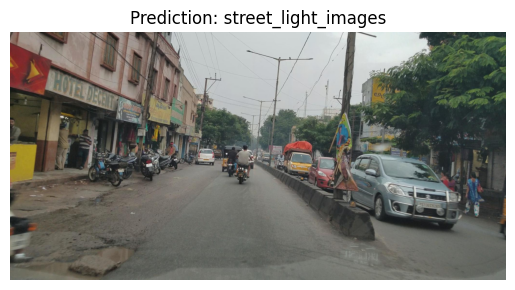

In [25]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# ============================
# STEP 1: Upload an image
# ============================
uploaded = files.upload()   # opens a file browser
for fn in uploaded.keys():
    img_path = fn
    print("Uploaded file:", img_path)

# ============================
# STEP 2: Load and preprocess
# ============================
img = image.load_img(img_path, target_size=IMG_SIZE)  # resize to model input
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

# ============================
# STEP 3: Predict
# ============================
pred = model.predict(img_array)
pred_class = np.argmax(pred, axis=1)[0]
confidence = np.max(pred)

print(f"Predicted Department: {class_names[pred_class]} (Confidence: {confidence:.2f})")

# ============================
# STEP 4: Show uploaded image
# ============================
plt.imshow(image.load_img(img_path))
plt.axis("off")
plt.title(f"Prediction: {class_names[pred_class]}")
plt.show()
